# Computational Analysis of Big Data - Final Project
## by Jill Brady & Ellie Packard

## 0. Data

**In directory with data file:**

$ sqlite3

sqlite> .open INPUT_FILE.sqlite

sqlite> .mode csv

sqlite> .output OUTPUT_FILE_1.csv

sqlite> SELECT FIRE_NAME, FIRE_YEAR, datetime(DISCOVERY_DATE) as

               DISCOVERY_DATE, DISCOVERY_DOY, DISCOVERY_TIME, 
               
               datetime(CONT_DATE) as CONT_DATE, CONT_DOY, 
               
               FIRE_SIZE, FIRE_SIZE_CLASS, OWNER_CODE, OWNER_DESCR,
               
               LATITUDE, LONGITUDE, STATE, COUNTY, STAT_CAUSE_DESCR, 
               
               STAT_CAUSE_CODE 
               
         FROM Fires 
         
         LIMIT 1000000;
         
sqlite> .output OUTPUT_FILE_2.csv

sqlite> SELECT FIRE_NAME, FIRE_YEAR, datetime(DISCOVERY_DATE) as 

               DISCOVERY_DATE, DISCOVERY_DOY, DISCOVERY_TIME, 
               
               datetime(CONT_DATE) as CONT_DATE, CONT_DOY, 
               
               FIRE_SIZE, FIRE_SIZE_CLASS, OWNER_CODE, OWNER_DESCR,  
               
               LATITUDE, LONGITUDE, STATE, COUNTY, STAT_CAUSE_DESCR, 
               
               STAT_CAUSE_CODE 
               
        FROM Fires 
        
        LIMIT 1000000 OFFSET 1000000;

In [206]:
from collections import defaultdict
import pandas as pd 
from matplotlib import pyplot as plt
import numpy as np
import geopandas as gpd
from bokeh.io import output_notebook, show, output_file, curdoc
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, FixedTicker, Slider, HoverTool
from bokeh.palettes import brewer
from bokeh.layouts import widgetbox, row, column
import json

In [1]:
column_names = ["FIRE_NAME", "FIRE_YEAR", "DISCOVERY_DATE", "DISCOVERY_DOY", "DISCOVERY_TIME", 
                "CONT_DATE", "CONT_DOY", "FIRE_SIZE", "FIRE_SIZE_CLASS", "OWNER_CODE", "OWNER_DESCR",
                "LATITUDE", "LONGITUDE", "STATE", "COUNTY", "STAT_CAUSE_DESCR", "STAT_CAUSE_CODE"]

In [2]:
data1 = pd.read_csv("fire_data1.csv", low_memory=False, index_col=None, header=None, names= column_names, dtype={"FIRE_YEAR": "int64"})
data2 = pd.read_csv("fire_data2.csv", low_memory=False, index_col=None, header=None, names= column_names, dtype={"FIRE_YEAR": "int64"})

data = data1.append(data2, ignore_index = True) 

## 1. Fire Trends
### Frequency of Fires Over Time

In [255]:
# List of each fire's year
fire_year = data['FIRE_YEAR']

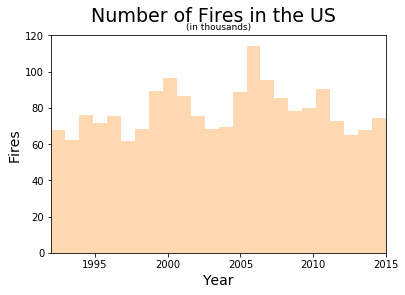

In [305]:
# Plot as histogram to show total number of fires each year
plt.hist(fire_year, bins=24, color="#fed8b1")
plt.suptitle("Number of Fires in the US", fontsize=19)
plt.title("(in thousands)", fontsize=9)
plt.xlabel("Year", fontsize=14)
plt.yticks((0,20000,40000,60000,80000,100000,120000), ('0','20', '40','60', '80','100','120'))
plt.ylabel("Fires", fontsize=14)
plt.xlim(1992,2015)
plt.savefig("Number of Fires in the US.jpg")
plt.show()

**Comment:** This plot shows a slight upward trend in fires between 1992 and 2015.

### Over time, how has the size of fires changed?

In [333]:
# Get avg and max fire size for each year
# Save in dict with year as key
size_avg = defaultdict(float)
size_max = defaultdict(float)

for yr in range(1992,2016):
    df = data[data['FIRE_YEAR'] == yr]
    sz = np.array(df['FIRE_SIZE'])
    size_avg[yr] = sum(sz)/len(sz)
    size_max[yr] = max(sz)

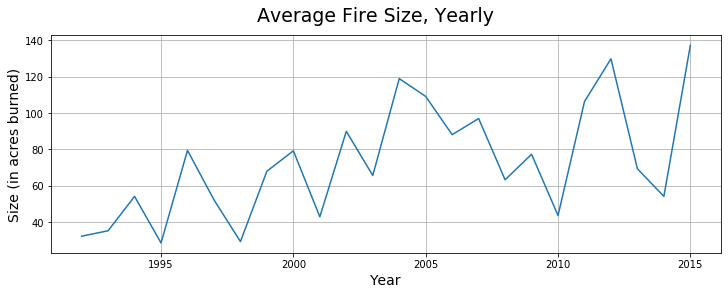

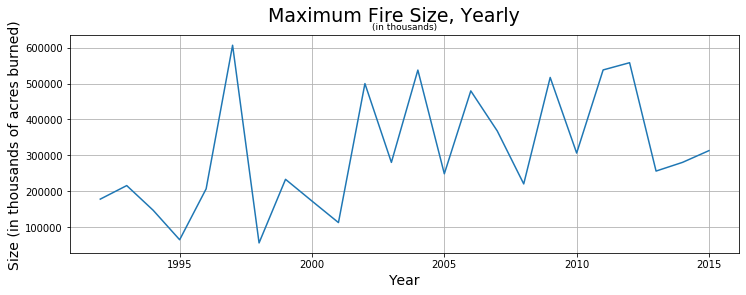

In [349]:
# Plot Avg Fire Size Yearly
fit, ax = plt.subplots(figsize=(12,4))
ax.plot([yr for yr in range(1992,2016)], list(size_avg.values()))                
plt.xlabel("Year", fontsize=14)
plt.ylabel("Size (in acres burned)", fontsize=14)
plt.suptitle("Average Fire Size, Yearly", fontsize=19)                 
ax.grid()
plt.savefig("Avg Fire Size.jpg")
plt.show()

# Plot Max Fire Size Yearly
fit, ax = plt.subplots(figsize=(12,4))
ax.plot([yr for yr in range(1992,2016)], list(size_max.values()))
plt.xlabel("Year", fontsize=14)
plt.ylabel("Size (in thousands of acres burned)", fontsize=14)
plt.suptitle("Maximum Fire Size, Yearly", fontsize=19)
plt.title("(in thousands)", fontsize=9)                      
ax.grid()
plt.savefig("Max Fire Size.jpg")
plt.show()

**Comment:** Both average fire size and maximum fire size show an increasing trend.

### While I'm looking into fire size, why not investigate how fire size class and fire damage are related

In [259]:
# Get fire size and fire size class data
fire_size = data['FIRE_SIZE']
fire_size_class = data['FIRE_SIZE_CLASS']

In [260]:
# Count number of fires in each fire size class
dd = defaultdict(int)
types = sorted(set(fire_size_class))
for type in types:
    dd[type] += 0
for cls in fire_size_class:
    dd[cls] += 1

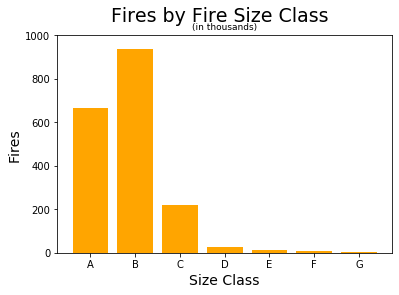

In [315]:
# Plot Number of Fires Per Class
plt.bar(range(len(dd)), list(dd.values()), color="orange")
plt.suptitle("Fires by Fire Size Class", fontsize=19)
plt.title("(in thousands)", fontsize=9)
plt.xlabel("Size Class", fontsize=14)
plt.ylabel("Fires", fontsize=14)
plt.yticks((0,200000,400000,600000,800000,1000000), ('0','200', '400','600', '800','1000'))
plt.xticks(range(len(dd)), list(dd.keys()))
plt.savefig("Number of Fires Per Class.jpg")
plt.show()

* Class A - one-fourth acre or less;
* Class B - more than one-fourth acre, but less than 10 acres;
* Class C - 10 acres or more, but less than 100 acres;
* Class D - 100 acres or more, but less than 300 acres;
* Class E - 300 acres or more, but less than 1,000 acres;
* Class F - 1,000 acres or more, but less than 5,000 acres;
* Class G - 5,000 acres or more.

In [267]:
#based on class add fire size to class's amount
A_damage = 0
B_damage = 0
C_damage = 0
D_damage = 0
E_damage = 0
F_damage = 0
G_damage = 0

for num in range(len(fire_size)):
    if fire_size_class[num] == 'A':
        A_damage += fire_size[num]
    if fire_size_class[num] == 'B':
        B_damage += fire_size[num]
    if fire_size_class[num] == 'C':
        C_damage += fire_size[num]
    if fire_size_class[num] == 'D':
        D_damage += fire_size[num]
    if fire_size_class[num] == 'E':
        E_damage += fire_size[num]
    if fire_size_class[num] == 'F':
        F_damage += fire_size[num]
    if fire_size_class[num] == 'G':
        G_damage += fire_size[num]

In [316]:
# Scale in millions
damage_byclass = [A_damage, B_damage, C_damage, D_damage, E_damage, F_damage, G_damage]
damage_byclass = [(i/1000000) for i in damage_byclass]

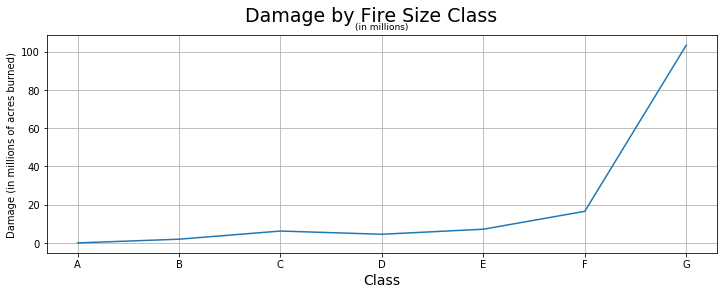

In [338]:
# Plot fire damage by size class
fit, ax = plt.subplots(figsize=(12,4))
ax.plot(['A','B','C','D','E','F','G'], damage_byclass)
plt.xlabel("Class",fontsize=14)
plt.ylabel("Damage (in millions of acres burned)", fontsize=10)
plt.title("(in millions)", fontsize=9)
plt.suptitle('Damage by Fire Size Class', fontsize=19)
ax.grid()
plt.savefig("Fire Damage by Fire Size Class.jpg")
plt.show()

### Over Time, have wildfires affected certain areas more? What geographical trends occurring?
#### (SEE NOTEBOOK 2)

### How have fire seasons changed over time?
#### (SEE NOTEBOOK 2)

## 2. Geographic Visualization

### Static Map - Fires & Fire Damage, Covering Data Between 1992-2015

In [177]:
shapefile = "ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp"

# Read shapefile
gdf = gpd.read_file(shapefile)[['name','name_alt','geometry' ]]
# Rename columns
gdf.columns = ['state_name', 'state_code', 'geometry']

In [178]:
state_abrev = ['MN', 'MT','ND', 'HI','ID', 'WA', 'AZ', 'CA','CO','NV', 'NM', 
 'OR', 'UT', 'WY', 'AR', 'IA', 'KS', 'MO', 'NE', 'OK', 'SD', 'LA',
 'TX', 'CT', 'MA', 'NH', 'RI', 'VT', 'AL', 'FL', 'GA', 'MS', 'SC',
 'IL', 'IN', 'KY', 'NC', 'OH', 'TN', 'VA','WI', 'WV', 'DE', 'DC', 'MD',
 'NJ', 'NY', 'PA', 'ME', 'MI', 'AK']

gdf['state_abrev'] = state_abrev

In [191]:
# Count Fires and Damages By State Between 1992 and 2015
states = data['STATE']
sizes = data['FIRE_SIZE']

fires_by_state= defaultdict(int)
damage_by_state= defaultdict(int)

index = 0
for index in range(len(states)):
    if states[index] != "PR":
        fires_by_state[states[index]] += 1
        damage_by_state[states[index]] += sizes[index]
    index += 1

In [193]:
# Create dataframe with total fires and total damages by state
col_state = list(fires_by_state.keys())
col_fires = list(fires_by_state.values())
col_damages = list(damage_by_state.values())
    
temp_df = pd.DataFrame()
temp_df["state_abrev"] = col_state
temp_df["TotFires"] = col_fires
temp_df["TotDamages"] = col_damages

In [194]:
# Merge geo data and tot fires and damages data
merged = gdf.merge(temp_df, left_on='state_abrev', right_on='state_abrev')

In [195]:
# Remove Hawaii and Alaska
merged = merged.set_index("state_abrev")
merged = merged.drop("HI", axis=0)
merged = merged.drop("AK", axis=0)
merged = merged.drop("PR", axis=0) ## DELETE

In [196]:
# Prepare for geopandas as json
merged_json = json.loads(merged.to_json())
json_data = json.dumps(merged_json)

In [252]:
# Geo data source
geosource = GeoJSONDataSource(geojson = json_data)

# Color palette
palette = brewer['OrRd'][5]
palette = palette[::-1]

# Color Bar
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 180000)
#ticker = FixedTicker(ticks=[0,36000,72000,108000,144000,180000])
#tick_labels = {'0': '0', '36000': '36,000', '72000':'72,000', '108000':'108,000', '144000':'144,000', '180000':'total fires'}
ticker = FixedTicker(ticks=[18000,54000,90000,126000,162000,180000])
tick_labels = {'18000': '0 - 36', '54000': '36 - 72', '90000':'72 - 108', 
               '126000':'108 - 144', '162000':'144+', '180000':'                    in thousands'}
color_bar = ColorBar(color_mapper=color_mapper, ticker=ticker, label_standoff=8,width = 500, height = 20, border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)

# Create Figure
p = figure(title = 'Fires in the US 1992-2015', plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.patches('xs','ys', source = geosource,fill_color = {'field' :'TotFires', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
p.add_layout(color_bar, 'below')

# Show
output_notebook()
show(p)

Loading BokehJS ...

In [250]:
# Geo source data
geosource = GeoJSONDataSource(geojson = json_data)

# Color Palette
palette = brewer['OrRd'][5]
palette = palette[::-1]

# Color Bar
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 14000000)

ticker = FixedTicker(ticks=[1400000, 4200000, 7000000, 9800000, 12600000, 14000000])
tick_labels = {'1400000': '0 - 2.8', '4200000': '2.8 - 5.6', '7000000':'5.6 - 8.4', 
               '9800000':'8.4 - 11.2', '12600000':'11.2+', 
               '14000000':'                              in millions of acres'}
color_bar = ColorBar(color_mapper=color_mapper, ticker=ticker, label_standoff=8,width = 500, height = 20, border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)



p = figure(title = 'Fire Damage in the US 1992-2015 (in acres burned)', plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.patches('xs','ys', source = geosource,fill_color = {'field' :'TotDamages', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
p.add_layout(color_bar, 'below')
output_notebook()
show(p)

Loading BokehJS ...

### Interactive Map - Fires & Fire Damage, Yearly

In [144]:
# DF for number of fires per state per year
yearly_fire_df = pd.DataFrame()
# DF for damages (acres burned) per state per year
yearly_dam_df = pd.DataFrame()

# Calculate totals by year
for start in range(1992,2016):
    df = data[data['FIRE_YEAR'] == start]
    
    f_by_state= defaultdict(int)
    d_by_state= defaultdict(int)
    
    st = list(df['STATE'])
    sz = list(df['FIRE_SIZE'])

    # Create keys for every state so that states not represented in 
    #certain years will still be part of final dataframe
    for abrev in state_abrev:
        if abrev != "HI" and abrev != "AK":
            f_by_state[abrev] += 0
            d_by_state[abrev] += 0
    
    # Count fires and damages by state
    i = 0
    for i in range (len(st)):
        if st[i] != "PR" and st[i] != "AK" and st[i] != "HI":
            f_by_state[st[i]] += 1
            d_by_state[st[i]] += (sz[i]/1000)
        i += 1
    
    # Convert dict keys and values to lists
    col_state = list(f_by_state.keys())
    col_fires = list(f_by_state.values())  
    col_damages = list(d_by_state.values())
    col_damages = [round(val) for val in col_damages]
        
    # Add first year to total fires and total damages dataframes
    if start == 1992:
        yearly_fire_df["state_abrev"] = col_state
        yearly_fire_df[str(start)] = col_fires
        yearly_dam_df["state_abrev"] = col_state
        yearly_dam_df[str(start)] = np.array(col_damages)/1000
    # Create temporary df with data from each respective year, then merge
    # with existing dataframe - so that ordering by state matches up
    else:
        temp_f = pd.DataFrame()
        temp_f["state_abrev"] = col_state
        temp_f[str(start)] = col_fires
        yearly_fire_df = yearly_fire_df.merge(temp_f, left_on='state_abrev', right_on='state_abrev')
        temp_d = pd.DataFrame()
        temp_d["state_abrev"] = col_state
        temp_d[str(start)] = col_damages
        yearly_dam_df = yearly_dam_df.merge(temp_d, left_on='state_abrev', right_on='state_abrev')

In [353]:
yearly_dam_df.head()

,state_abrev,2015,2014,2013,2012,2011,2010,2009,2008,2007,...,2001,2000,1999,1998,1997,1996,1995,1994,1993,1992
0,MN,28952.47,3984.64,21936.47,64901.04,139066.68,35680.34,11715.91,21197.02,164404.56,...,23136.32,69170.17,32858.86,49139.65001,20708.74,29633.94,46067.31,37150.32,19087.71,30182.13
1,MT,350033.86,34919.92,77404.18,1007209.58,139286.18,57476.10,53706.39,169869.30,744542.86,...,162549.19,822860.31,117459.34,101357.27000,11343.13,208840.45,25183.95,265689.35,12598.41,38591.72
2,ND,25794.07,3915.45,6693.69,41722.89,4049.38,3754.80,3314.16,29906.05,18860.90,...,6567.30,18171.70,70997.60,7760.10000,6203.80,4801.80,2047.60,11743.30,3923.90,6373.90
3,ID,791026.11,198892.57,740325.50,1775106.39,409349.05,643868.16,23907.91,175190.36,2184656.24,...,192801.62,1350786.48,416185.82,151299.30000,42902.40,896659.90,268681.30,729029.60,7978.20,684658.90
4,WA,1161646.38,449900.92,153546.66,280766.41,38613.25,93046.30,87063.29,117879.42,264591.02,...,223780.10,285252.60,26175.17,111620.70000,27563.10,148134.10,6727.80,271438.10,22629.00,89681.05


### (SEE MAP NOTEBOOKS 3 AND 4)

Create .gif for blog post:

In [ ]:
from PIL import Image
import os
import io

fpath = "/Users/jillianbrady/Desktop/gif"
images = []

top=95
left=0
right=970
bottom=750

for item in os.listdir(fpath):
    with open ((fpath + '/' + item), 'rb') as file:
        im = Image.open(io.BytesIO(file.read()))
    im = im.crop((left, top, right, bottom))
    images.append(im)

images[0].save('/Users/jillianbrady/Desktop/new.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=600, loop=0)